In [1]:
using Plots
using DelimitedFiles
using WindTunnelFlow
using JSON
using Statistics

In [2]:
root_dir = "/Users/beckers/WindTunnelFlow_simulations"
project_sub_dir = "cawt_job"
job_id = 5647927
case = "cawt_job_5647927_15_AFUWT_Grid_Re_2.5_Re_400_aoa_20_Qratio_0.3"

"cawt_job_5647927_15_AFUWT_Grid_Re_2.5_Re_400_aoa_20_Qratio_0.3"

In [9]:
dir = "/Users/beckers/WindTunnelFlow_simulations/cawt_job_5647927_8_AFUWT_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.2"
json_file = "$(dir)/AFUWT_gaussian_suction.json"
Q_and_V_probe_file = "$(dir)/5647927_8_Q_and_V_probe.txt"
force_wind_tunnel_file = "$(dir)/5647927_8_force_wind_tunnel.txt"

"/Users/beckers/WindTunnelFlow_simulations/cawt_job_5647927_8_AFUWT_Grid_Re_2.5_Re_400_aoa_10_Qratio_0.2/5647927_8_force_wind_tunnel.txt"

In [64]:
function read_vorticity!(w,dir,i)
    files = readdir(dir)
    match_string = "snapshot_$(i).*vorticity_wind_tunnel"
    f_idx = findall(f->occursin(Regex(match_string),f),files)
    println("read_vorticity! => f_idx = $(f_idx)")
    if length(f_idx) == 1
        f = files[f_idx[1]]
        println(f)
        f = joinpath(dir,f)
        w_data = readdlm(f, Float64)
        println(size(w_data))
        w.data .= w_data
    else
        println("i is out of bounds")
    end
    return w
end

function read_timestamp(dir,i)
    files = readdir(dir)
    match_string = "snapshot_$(i).*time_wind_tunnel"
    f_idx = findall(f->occursin(Regex(match_string),f),files)
    println("read_timestamp => f_idx = $(f_idx)")
    snapshots_time = Float64[]
    f = files[f_idx[1]]
    println(f)
    f = joinpath(dir,f)
    t = readdlm(f, Float64)[1]
    return t
end

function q_criterion!(Q::Nodes{Dual},vel_grad,sys,nodes_primal_tmp::Nodes{Primal})
    Q .= 0.5 .* (vel_grad.dudy .+ vel_grad.dvdx) .^ 2
    grid_interpolate!(nodes_primal_tmp,Q)
    nodes_primal_tmp .+= vel_grad.dudx .+ vel_grad.dvdy
    nodes_primal_tmp .= .- abs.(nodes_primal_tmp) # -|S|²
    grid_interpolate!(Q,nodes_primal_tmp)
    Q .+= abs.(0.5 .* (vel_grad.dudy - vel_grad.dvdx) .^ 2) # |Ω|² - |S|²
    Q .*= 0.5
    return Q
end

q_criterion! (generic function with 1 method)

In [10]:
inputs = JSON.parsefile(json_file)
t_suction = inputs["t_suction"]
σ_suction = inputs["sigma_suction"]

force_wind_tunnel = readdlm(force_wind_tunnel_file, '\t', Float64, '\n');
Q_and_V_probe = readdlm(Q_and_V_probe_file, '\t', Float64, '\n');
t = force_wind_tunnel[:,1];
C_D = force_wind_tunnel[:,2];
C_L = force_wind_tunnel[:,3];
Q_Q_in = Q_and_V_probe[:,2];

In [26]:
# Create the wind tunnel problem
include("AFUWT_create_sys.jl")

wt_walls = create_windtunnel_boundaries(g,params,withinlet=true);

PhysicalGrid{2}((1512, 448), (756, 224), 0.00625, ((-4.71875, 4.71875), (-1.39375, 1.39375)), 4)
creating flat plate airfoil
creating gaussian gust
Creating WindTunnelProblem... done


In [27]:
t_suction_start = t_suction - 3 * σ_suction
t_suction_end = t_suction + 3 * σ_suction
suction_idxs = findall(t->t_suction_start <= t <= t_suction_end,t)
C_L_max_idx = findmax(C_L[suction_idxs])[2] + suction_idxs[1] - 1
C_L_min_idx = findmin(C_L[suction_idxs])[2] + suction_idxs[1] - 1

frames_times = [
    t_suction_start,
    t[C_L_max_idx],
    t_suction,
    t[C_L_min_idx],
    t_suction_end,
    t_suction_end + 1 * V_in_star / c_star]
frames_idx = [findmin(abs.(frames_times[i] .- t))[2] for i in 1:length(frames_times)];

In [28]:
frames_idx

6-element Vector{Int64}:
 383
 397
 401
 405
 419
 459

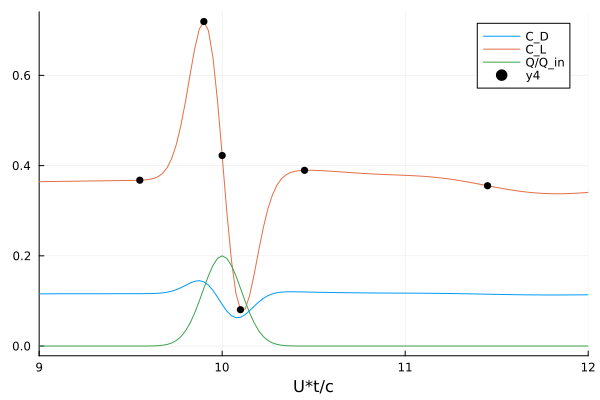

In [29]:
plot(t,force_wind_tunnel[:,2],label="C_D")
plot!(t,force_wind_tunnel[:,3],label="C_L")
plot!(t,Q_and_V_probe[:,2],label="Q/Q_in")
# vline!(t[frames_idx],c=:black,ls=:dash)
scatter!(t[frames_idx],force_wind_tunnel[frames_idx,3],c=:black,ls=:dash)
plot!(xlabel="U*t/c",xlim=[9,12])

In [30]:
frames_times

6-element Vector{Float64}:
  9.55
  9.9
 10.0
 10.1
 10.45
 11.45

In [41]:
frames_idx = [377, 381, 385]

3-element Vector{Int64}:
 377
 381
 385

In [71]:
readdlm("$(dir)/grid_test.txt")
PhysicalGrid()

7×2 Matrix{Any}:
 1512         ""
  442         ""
  756         ""
  221         ""
    0.00625   ""
   -4.71875  4.71875
   -1.375    1.375

In [68]:
fig_xlim = [-0.75,0.75]
fig_ylim = [-0.75,0.75]
# fig_xlim = xlim
# fig_ylim = ylim
y_probe_ψ = range(ylim[1],ylim[2],50)
x_probe_ψ = zeros(length(y_probe_ψ)) .+ 0.0

plot_list = []

v = zeros_grid(sys)
w = zeros_gridcurl(sys)
ψ = zeros_gridcurl(sys)
Q = Nodes(Dual,size(g))
nodes_primal_tmp = Nodes(Primal,size(g))
∇v = EdgeGradient(Primal,Dual,size(g));

read_vorticity!(w,dir,frames_idx[1]);
ViscousFlow.velocity!(v, w, sys, frames_idx[1]);
grad!(∇v,v)
∇v ./= cellsize(sys)
q_criterion!(Q,∇v,sys,nodes_primal_tmp);

n_parallel_points = 10
offset = 0.15
airfoil_pts = length(airfoil)
x_probe_Q = range(airfoil.x[1] + offset * sin(α*pi/180),airfoil.x[end] + offset * sin(α*pi/180),n_parallel_points)
y_probe_Q = range(airfoil.y[1] + offset * cos(α*pi/180),airfoil.y[end] + offset * cos(α*pi/180),n_parallel_points)

Q_fcn = interpolatable_field(Q,g)
Q_probe = Q_fcn.(x_probe_Q,y_probe_Q)
Q_mean = mean(Q_probe)
Q_std = std(Q_probe)
Q_levels = range(Q_mean,Q_mean+Q_std,10)

println(Q_levels)

for i in frames_idx[1:3]
    println("i = $(i)")
    read_vorticity!(w,dir,i);
    t_i = read_timestamp(dir,i);
    ViscousFlow.streamfunction!(ψ,w,sys,t_i);

    ψ_fcn = interpolatable_field(ψ,g)
    ψ_probe = ψ_fcn.(x_probe_ψ,y_probe_ψ)

    ViscousFlow.velocity!(v, w, sys, t_i);
    grad!(∇v,v)
    ∇v ./= cellsize(sys)
    q_criterion!(Q,∇v,sys,nodes_primal_tmp);

    p = plot(ψ,g,c=:gray,xlim=fig_xlim,ylim=fig_ylim,levels=ψ_probe,title="time = $(t[frames_idx])")
    plot!(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=Q_levels,c=:black)
    plot!(airfoil,fc=:white,lc=:black)
    plot!(wt_walls,c=:black)

    push!(plot_list,p)
end

# gif(anim,fps=10)

read_vorticity! => f_idx = [13]
5647927_8_snapshot_377_vorticity_wind_tunnel.txt
(1512, 448)
0.6340983847272834:0.08507563083826579:1.3997790622716755
i = 377
read_vorticity! => f_idx = [13]
5647927_8_snapshot_377_vorticity_wind_tunnel.txt
(1512, 448)
read_timestamp => f_idx = [11]
5647927_8_snapshot_377_time_wind_tunnel.txt
i = 381
read_vorticity! => f_idx = [17]
5647927_8_snapshot_381_vorticity_wind_tunnel.txt
(1512, 448)
read_timestamp => f_idx = [15]
5647927_8_snapshot_381_time_wind_tunnel.txt
i = 385
read_vorticity! => f_idx = [21]
5647927_8_snapshot_385_vorticity_wind_tunnel.txt
(1512, 448)
read_timestamp => f_idx = [19]
5647927_8_snapshot_385_time_wind_tunnel.txt


In [66]:
length(plot_list)

3

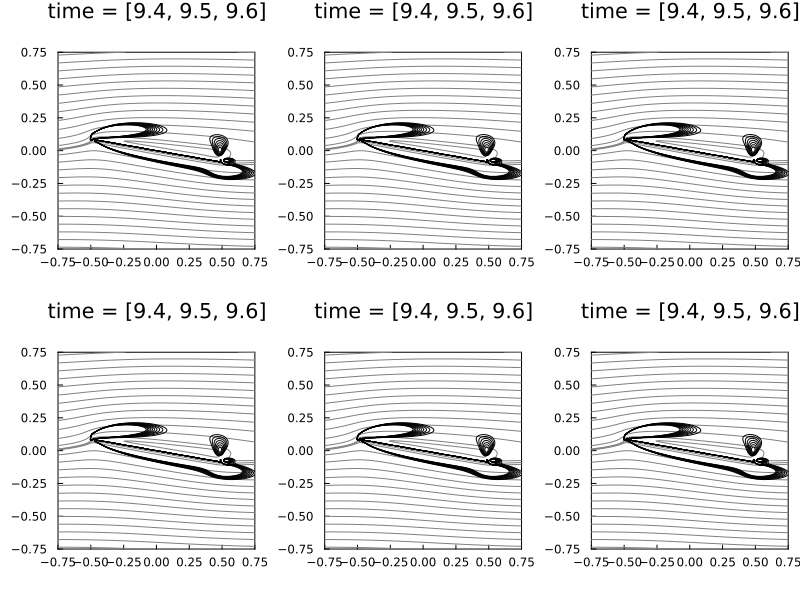

In [67]:
plot(plot_list...,plot_list..., layout = (2, 3), size=(800,600))

In [21]:
maximum(Q)

LoadError: UndefVarError: Q not defined

In [22]:
plot(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=range(0.0001,0.0004,10),c=:black)

LoadError: UndefVarError: Q not defined

In [23]:
y_probe = range(0.0,1.0*H_TS_star,50) .+ y_O_WT_star
x_probe = zeros(length(y_probe)) .+ 0.0

ψ_fcn = interpolatable_field(ψ,g)
ψ_probe = ψ_fcn.(x_probe,y_probe)

# plot(ψ,g,c=:gray,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=ψ_probe)
plot(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75])
# plot!(w,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75])
plot!(airfoil,fc=:white,lc=:black)
plot!(wt_walls,c=:black)
scatter!(x_probe,y_probe)

LoadError: UndefVarError: H_TS_star not defined

In [24]:
n_parallel_points = 10
offset = 0.15
airfoil_pts = length(airfoil)
x_probe = range(airfoil.x[1] + offset * sin(α*pi/180),airfoil.x[end] + offset * sin(α*pi/180),n_parallel_points)
y_probe = range(airfoil.y[1] + offset * cos(α*pi/180),airfoil.y[end] + offset * cos(α*pi/180),n_parallel_points)

Q_fcn = interpolatable_field(Q,g)
Q_probe = Q_fcn.(x_probe,y_probe)
Q_mean = mean(Q_probe)
Q_std = std(Q_probe)
Q_levels = range(Q_mean,Q_mean+Q_std,10)

# plot(ψ,g,c=:gray,xlim=[-0.75,0.75],ylim=[-0.25,0.25],levels=ψ_probe)
plot(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=Q_levels)
# plot!(w,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75])
plot!(airfoil,fc=:white,lc=:black)
plot!(wt_walls,c=:black)
scatter!(x_probe,y_probe)

LoadError: UndefVarError: airfoil not defined

In [25]:
plot(Q,g,xlim=[-0.75,0.75],ylim=[-0.75,0.75],levels=range(10,100,100))

LoadError: UndefVarError: Q not defined

In [3]:
grid_Re_array = [2.5];
Re_array = [400];
α_array = [0];
Q_ratio_array = [0.1];

In [4]:
force_wt_list = Any[]
force_no_wt_list = Any[]
force_wagner_list = Any[]
label_list = String[]

task_id = 1
for grid_Re in grid_Re_array
    for Re in Re_array
        for α in α_array
            for Q_ratio in Q_ratio_array
                case_dir = "$(project_sub_dir)_$(job_id)_$(task_id)_$(case)_Grid_Re_$(grid_Re)_Re_$(Re)_aoa_$(α)_Qratio_$(Q_ratio)"
                dir = joinpath(root_dir,case_dir)
                if isdir(dir)
                    file_root = joinpath(dir,"$(job_id)_$(task_id)")
                    force_wt = readdlm("$(file_root)_force_wind_tunnel.txt", '\t', Float64, '\n');
                    push!(force_wt_list,force_wt)
                    force_no_wt = readdlm("$(file_root)_force_no_wind_tunnel.txt", '\t', Float64, '\n');
                    push!(force_no_wt_list,force_no_wt)
                    force_wagner = readdlm("$(file_root)_force_wagner.txt", '\t', Float64, '\n');
                    push!(force_wagner_list,force_wagner)
                    label = "Grid_Re_$(grid_Re)_Re_$(Re)_aoa_$(α)_Qratio_$(Q_ratio)"
                    push!(label_list,label)
                    
                else
                    println("$(dir) doesn't exist")
                end
                task_id += 1
            end
        end
    end
end

/Users/beckers/WindTunnelFlow_simulations/cawt_job_5647927_1_cawt_job_5647927_15_AFUWT_Grid_Re_2.5_Re_400_aoa_20_Qratio_0.3_Grid_Re_2.5_Re_400_aoa_0_Qratio_0.1 doesn't exist


In [5]:
p = plot(xlabel="convective time",ylabel="C_D",ylim=[0,1])
for task_id in [1]
    plot!(force_wt_list[task_id][:,1],force_wt_list[task_id][:,2],label=label_list[task_id])
end
p

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

In [6]:
i_match = 1230
i_wagner_sxtart = 1230
i_sim_stop = length(force_wt_list[1][:,1])-10

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

In [7]:
# p = plot(xlabel="convective time",ylabel="C_L",ylim=[-0.3,1.1],legend=:topright,size=(400,600),labelfontsize=12,tickfontsize=10,legendfontsize=10)
p = plot(xlabel="convective time",ylabel="C_L",xlim=[1,4],ylim=[-0.15,0.21],legend=:topright,size=(600,300),labelfontsize=12,tickfontsize=9,legendfontsize=10)
# for task_id in [1]
task_id = 1
#     plot!(force_wt_list[task_id][:,1][1:i_sim_stop],force_wt_list[task_id][:,3][1:i_sim_stop],label="wind tunnel",xlim=[0,12],lw=2)
#     plot!(force_no_wt_list[task_id][:,1][1:i_sim_stop],force_no_wt_list[task_id][:,3][1:i_sim_stop],label="no wind tunnel",lw=2)
#     plot!(force_wagner_list[task_id][:,1][i_wagner_start:i_sim_stop],force_wagner_list[task_id][:,3][i_wagner_start:i_sim_stop].-force_wagner_list[task_id][:,3][i_match].+force_wt_list[task_id][:,3][i_match],label="Wagner",lw=2)
    plot!(force_wt_list[task_id][:,1],force_wt_list[task_id][:,3],label="wind tunnel",lw=1.5)
    plot!(force_no_wt_list[task_id][:,1],force_no_wt_list[task_id][:,3],label="no wind tunnel",lw=1.5)
    plot!(force_wagner_list[task_id][:,1],force_wagner_list[task_id][:,3],label="Wagner",lw=1.5)
# end
savefig("~/Desktop/DFD22/$(label_list[task_id]).pdf")
p

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]